In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import healpy as hp
from statistics import mean, stdev
import os

# Compute Rényi entropies for q = 1 to 5
nside = 8   
def compute_renyi_entropy(input_file, output_file,rmin, rmax, Nside=nside, nbin=1):
    Npix = hp.nside2npix(Nside)

    # Load data
    df = pd.read_csv(input_file, sep="\t", header=None)
    df.columns = ['r','th','ph']
    r1 = df['r'].to_numpy()
    th1 = df['th'].to_numpy()
    ph1 = df['ph'].to_numpy()

    # Set up radial bins    compute_renyi_entropy(f_in, f_out1)

    #rmin, rmax = np.min(r1), np.max(r1)
    dr = (rmax - rmin) / nbin

    # Initialize counts and effective numbers
    m = np.zeros((nbin, Npix), dtype=float)
    Neff = np.zeros(nbin, dtype=int)

    # Fill pixel counts per radial bin
    for rr, tt, pp in zip(r1, th1, ph1):
        for j in range(nbin):
            if rmin <= rr <= (rmin + (j+1) * dr):
                px = hp.ang2pix(Nside, tt, pp)
                m[j][px] += 1
                Neff[j] += 1

    # Normalize to get probabilities
    p = np.zeros((nbin, Npix), dtype=float)
    for i in range(nbin):
        for px in range(Npix):
            if Neff[i] > 0:
                p[i][px] = m[i][px] / Neff[i]

    H = np.zeros((nbin, 5), dtype=float)
    a = np.zeros((nbin, 5), dtype=float)
    
    for k in range(5):
        h = np.zeros(nbin, dtype=float)
        q = k + 1
        if q == 1:
            for i in range(nbin):
                for px in range(Npix):
                    if p[i][px] > 0:
                        H[i][k] -= p[i][px] * np.log10(p[i][px])
        else:
            for i in range(nbin):
                for px in range(Npix):
                    h[i] += p[i][px] ** q
                if h[i] > 0:
                    H[i][k] = np.log10(h[i]) / (1 - q)

        for i in range(nbin):
            a[i][k] = H[i][k]

    # Construct output: radius and entropy values
    R = np.zeros(nbin)
    for b in range(nbin):
        R[b] = rmin + (b+1)*dr
        
    df1=pd.DataFrame(data=a)
    df2=pd.DataFrame(data=R)
    df3= pd.concat([df2,df1], axis=1, join='inner')
    df3.to_csv(output_file, sep='\t', header=False, index=False)
    

In [2]:
output_dir1 = "Randomized_data"
os.makedirs(output_dir1, exist_ok=True)  # Create the directory if it doesn't exist

output_dir2 = "anisotropy"

os.makedirs(output_dir2, exist_ok=True)  # Create the directory if it doesn't exist

# nf = 100  # number of samples

f = '../data_prep/mask1/masked_sample_2.dat'
df1 = pd.read_csv(f,sep="\t",header = None)
df1.columns = ['r','th','ph']
r = df1['r'].to_numpy()    # in Mpc
th = df1['th'].to_numpy()
ph = df1['ph'].to_numpy()  

# R_max = np.max(r)
R_max = 5000
R_min = np.min(r)

#####################################################################################
f1 = '../data_prep/mask1/non_zero_pix_id_2.dat'
   
df4 = pd.read_csv(f1,sep="\t",header = None)
df4.columns = ['id_list']
id_pix = df4['id_list'].to_numpy()
#####################Randomization###################################################
max_cos= 1.0
min_cos = -1.0
no_rand_files = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150])

# for nr in range(len(no_rand_files)):

for f in range(150):
    
    random.seed((f+1))
    num_points = len(r)
    
    valid_theta = []
    valid_phi = []
    
    while(len(valid_theta) < num_points):
        
        cos_theta = random.uniform(min_cos, max_cos)  
        phi = random.uniform(0, 2*np.pi) 
            
        theta = np.arccos(cos_theta)
        pix = hp.ang2pix(nside, theta, phi)
        
        if pix in id_pix:
            valid_theta.append(theta)
            valid_phi.append(phi)
     
    v_theta = np.array(valid_theta)
    v_phi = np.array(valid_phi)

    dict1 = {'r': r, 'th': v_theta, 'ph': v_phi } 
    fd = pd.DataFrame(dict1)

    out = 'Randomized_data/rand' + str(f+1) + '.dat'
    fd.to_csv(out, sep="\t", header=None, index=False)
        
    f_out = 'anisotropy/anis_rand' + str (f+1) + '.dat'
        
    compute_renyi_entropy(out,f_out,R_min,R_max)

In [3]:
nbin = 1
for n in range(len(no_rand_files)):    
    criteria = np.zeros((no_rand_files[n],nbin)) 
    mean_crit = np.zeros(nbin) 
    d_crit = np.zeros(nbin) 
    for f in range(no_rand_files[n]):
        # file = 'anisotropy/anis_s' + str(no_rand_files[n]) + '_rand' + str (f+1) + '.dat'
        file = 'anisotropy/anis_rand' + str (f+1) + '.dat'     
        # RR = np.loadtxt(file)[:,0]
        # a1 = np.loadtxt(file)[:,1]
        # a2 = np.loadtxt(file)[:,2]
        # a3 = np.loadtxt(file)[:,3]
        # a4 = np.loadtxt(file)[:,4]
        # a5 = np.loadtxt(file)[:,5]

        data = np.loadtxt(file)

        # Only one row, data is shape (6,)
        RR = np.array([data[0]])
        a1 = np.array([data[1]])
        a2 = np.array([data[2]])
        a3 = np.array([data[3]])
        a4 = np.array([data[4]])
        a5 = np.array([data[5]])
        a_mean = np.zeros(len(RR))
        stab_cri = np.zeros(len(RR))
        for i in range(len(RR)):
            a_mean[i] = (a1[i]+a2[i]+a3[i]+a4[i]+a5[i])/5.0
            stab_cri[i] = np.sqrt((1/5)*((a1[i]-a_mean[i])**2+(a2[i]-a_mean[i])**2+(a3[i]-a_mean[i])**2
                                    +(a4[i]-a_mean[i])**2+(a5[i]-a_mean[i])**2))
    
        criteria[f] = stab_cri/a_mean
    for i in range(nbin):
        list_crit = []
        for j in range(no_rand_files[n]):
            list_crit.append(criteria[j][i])
            
         
        mean_crit[i] = mean(list_crit)        
        d_crit[i] = stdev(list_crit)
        
    dict1 = {'r': RR, 'crit':mean_crit, 'sd': d_crit } 
    fd = pd.DataFrame(dict1)
    f_name1 = 'sample_rand_'+str(no_rand_files[n])+'_criteria.csv' 
    fd.to_csv(f_name1,index=False)
   

In [4]:
standered_err = []
mean_disp = []
for n in range(len(no_rand_files)):
    f_name2 = 'sample_rand_'+str(no_rand_files[n])+'_criteria.csv' 
    df2 = pd.read_csv(f_name2)
    R_rand = df2['r'].to_numpy()
    cri_rand = df2['crit'].to_numpy()
    d_cri_rand = df2['sd'].to_numpy()

    standered_err.append(d_cri_rand / np.sqrt(no_rand_files[n]))
    mean_disp.append(cri_rand)

In [5]:
standered_err = np.array(standered_err)
mean_disp = np.array(mean_disp)

diff_mean_disp = np.abs(mean_disp - mean_disp[-1])

In [6]:
# Ensure inputs are all flat arrays
no_rand_files = np.array(no_rand_files).flatten()
mean_disp = np.array(mean_disp).flatten()
standered_err = np.array(standered_err).flatten()
diff_mean_disp = np.abs(mean_disp - mean_disp[-1]).flatten()
df_out = pd.DataFrame({
    'no_rand_files': no_rand_files,
    'mean_disp': mean_disp,
    'standered_err': standered_err,
    'abs_diff_from_last': diff_mean_disp
})

# Save to CSV
df_out.to_csv("dispersion_analysis_plot_data.csv", index=False)


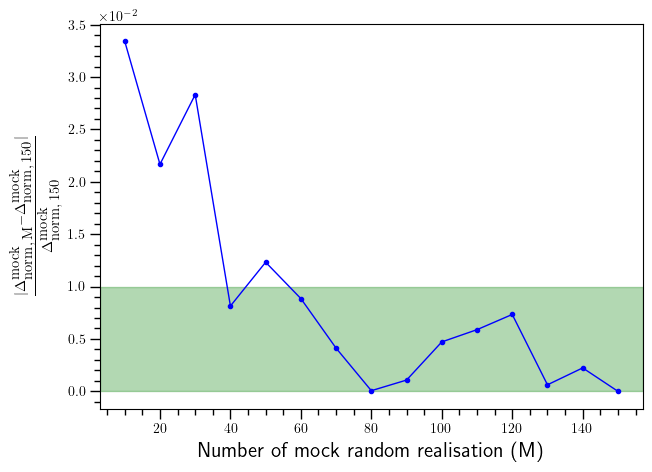

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter

# LaTeX rendering
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize=(7, 5))
ax.set_xlabel("Number of mock random realisation (M)", fontsize=15)
# ax.set_ylabel(r"$|{\psi (5000 Mpc)} - \psi_{\mathrm{last}} (5000 Mpc)|$", fontsize=14)
ax.set_ylabel(
    r"$\frac{|\Delta_{\scriptstyle \mathrm{norm},\, \mathrm{M}}^{\scriptstyle \mathrm{mock}} - \Delta_{\scriptstyle \mathrm{norm},\,150}^{\scriptstyle \mathrm{mock}}|}{\Delta_{\scriptstyle \mathrm{norm},\,150}^{\scriptstyle \mathrm{mock}}}$",
    fontsize=15
)

ax.plot(no_rand_files, diff_mean_disp/mean_disp[-1], marker='o',markersize = 3 ,lw=1, c='blue')

# Axis formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(formatter)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=1, labelsize=10)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='k')

# Optional text annotation
# ax.text(0.7, 0.9, r"Stability convergence", transform=ax.transAxes, fontsize=12)
#ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax.axhspan(0, 0.01, color='green', alpha=0.3) #, label=r"$<$ 1\% threshold")
# Optional legend
#ax.legend(fontsize=10, frameon=False)
plt.savefig("../plots/dispersion_shift.pdf", bbox_inches='tight')
plt.show()


In [8]:
for n in range(len(no_rand_files)):
    f_n = 'sample_rand_'+str(no_rand_files[n])+'_criteria.csv' 
    os.remove(f_n)
    
import shutil
shutil.rmtree('Randomized_data')
shutil.rmtree('anisotropy')
  